<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/LocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install kornia
!pip install kornia_moons

In [47]:
import torch
import torch.nn as nn
import torchvision
import kornia as K

class PreprocessPipeline(nn.Module):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((320, 240)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = x.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

# Inicializa o pipeline de preprocessamento
preprocess = PreprocessPipeline()


In [88]:
from kornia.feature import LocalFeatureMatcher,GFTTAffNetHardNet

# Carregar as duas imagens utilizando torchvision
img1 = torchvision.io.read_image("image1.jpg").float() / 255.0
img2 = torchvision.io.read_image("image2.jpg").float() / 255.0

# Aplica o pipeline de preprocessamento à imagem
img1_preprocessed = preprocess(img1)
# Aplica o pipeline de preprocessamento à imagem
img2_preprocessed = preprocess(img2)


input = {"image0": img1_preprocessed, "image1": img2_preprocessed}
gftt_hardnet_matcher = LocalFeatureMatcher(
    GFTTAffNetHardNet(100), K.feature.DescriptorMatcher('snn', 0.9)
)
out = gftt_hardnet_matcher(input)

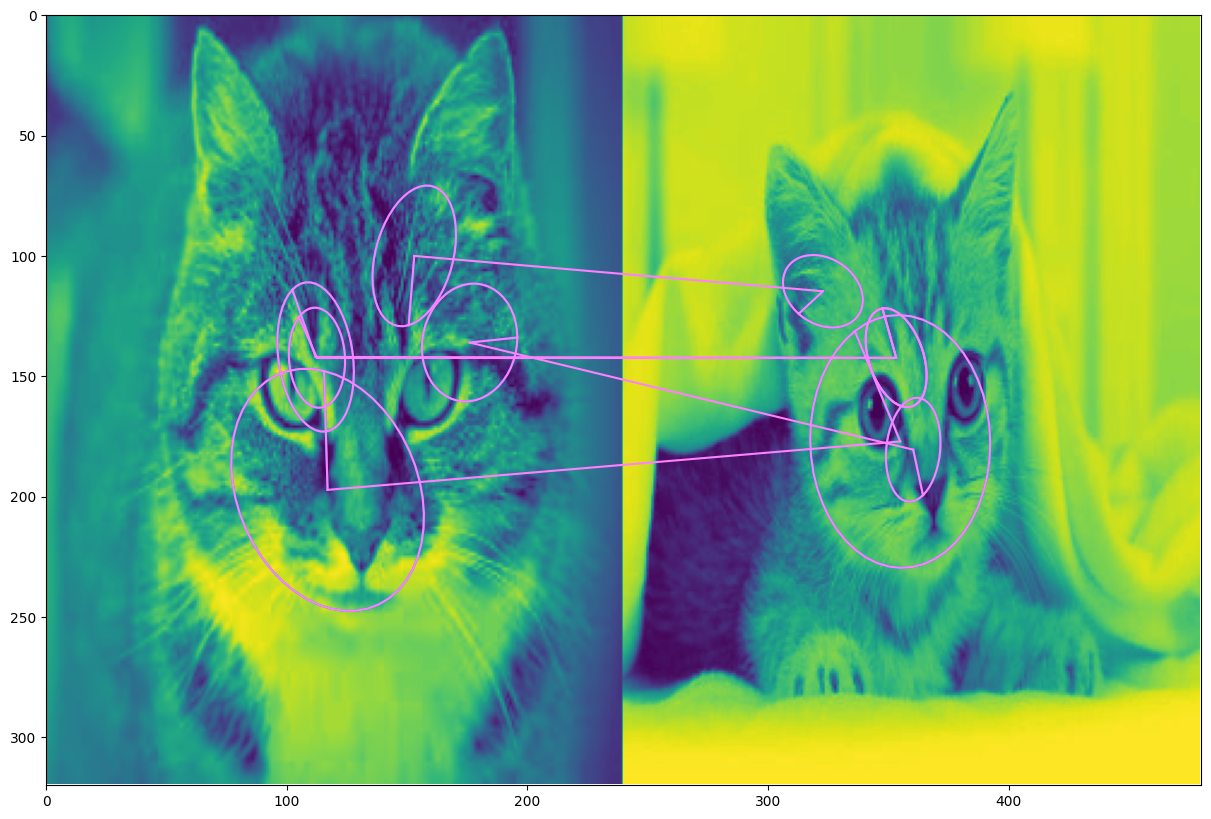

In [89]:
from kornia_moons.viz import draw_LAF_matches
n = out['keypoints1'].shape[0]
matching = torch.tensor([[i, i] for i in range(n)])
# Agora, desenhe os matchings
draw_LAF_matches(
    out['lafs0'],
    out['lafs1'],
    matching,
    K.tensor_to_image(img1_preprocessed.squeeze()),  # Garante que as imagens estão sem a dimensão de batch
    K.tensor_to_image(img2_preprocessed.squeeze()),
    None,  # Ou None se você não tiver uma máscara de inliers
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)